In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


2024-12-22 11:32:30.095670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 11:32:30.202341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734841950.247611  144296 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734841950.260153  144296 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 11:32:30.358076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [3]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(2024)

In [4]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train
test

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""00c0cd71""","""Winter""",7,0,"""Summer""",51,"""Spring""",29.315775,54.0,121.6,null,80,75,99,"""Spring""",4,5,32,"""Spring""",6,1,null,null,null,null,0,0,12.0,1,15.0,1,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",35,50,"""Winter""",2
"""00d56d4b""","""Spring""",5,1,"""Summer""",80,"""Spring""",17.284504,44.0,47.6,null,61,76,109,"""Spring""",null,null,null,"""Spring""",0,0,null,null,null,null,0,0,10.5,1,10.0,1,7.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",37,53,"""Spring""",0
"""00d9913d""","""Fall""",10,1,null,null,"""Fall""",19.893157,55.0,85.6,30.0,null,81,null,null,null,null,null,"""Fall""",5,0,null,null,null,null,0,0,0.0,0,0.0,0,9.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",1


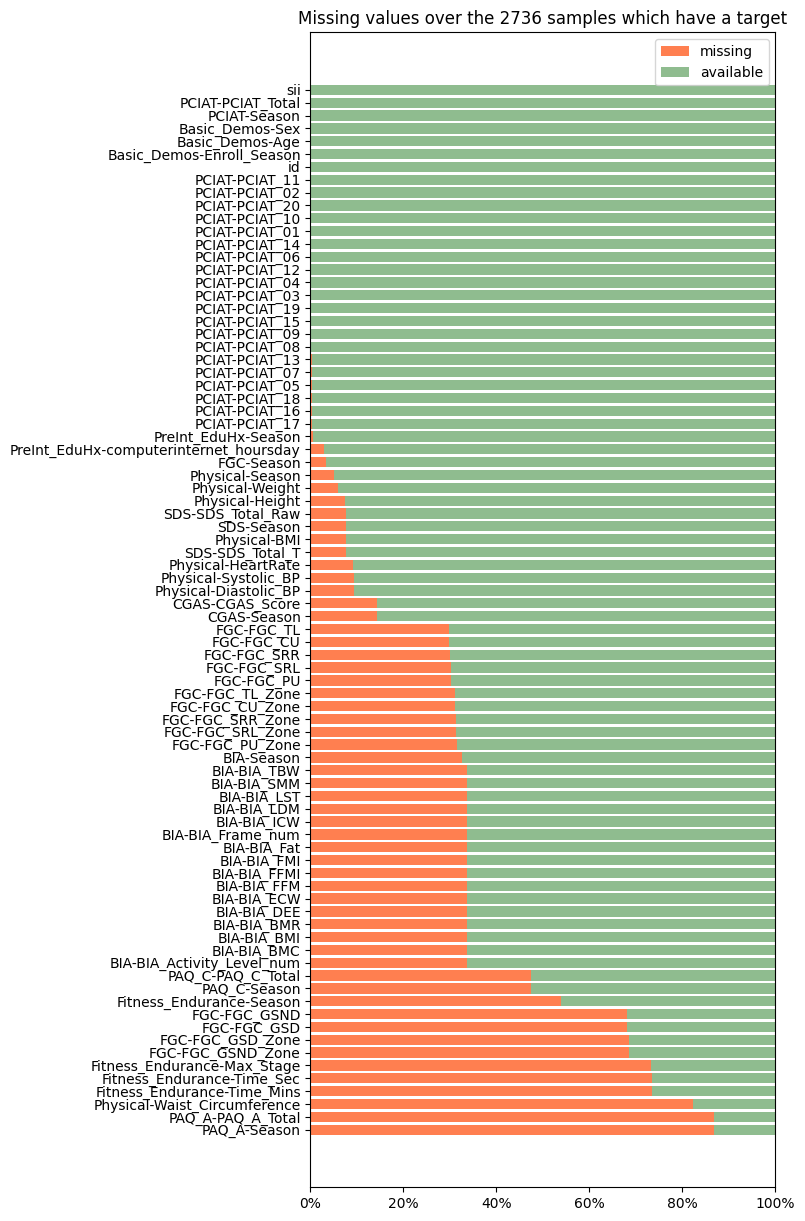

In [18]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

In [19]:
missing_count

feature,null_count,null_ratio
str,u32,f64
"""PAQ_A-Season""",2373,0.867325
"""PAQ_A-PAQ_A_Total""",2373,0.867325
"""Physical-Waist_Circumference""",2253,0.823465
"""Fitness_Endurance-Time_Mins""",2008,0.733918
"""Fitness_Endurance-Time_Sec""",2008,0.733918
…,…,…
"""Basic_Demos-Age""",0,0.0
"""Basic_Demos-Sex""",0,0.0
"""PCIAT-Season""",0,0.0



Detailed column information:

0-25% missing:
- Physical-Season: 16.41%
- Physical-BMI: 23.69%
- Physical-Height: 23.56%
- Physical-Weight: 22.32%
- FGC-Season: 15.51%
- PreInt_EduHx-Season: 10.61%
- PreInt_EduHx-computerinternet_hoursday: 16.64%

25-50% missing:
- CGAS-Season: 35.48%
- CGAS-CGAS_Score: 38.86%
- Physical-Diastolic_BP: 25.40%
- Physical-HeartRate: 25.08%
- Physical-Systolic_BP: 25.40%
- FGC-FGC_CU: 41.36%
- FGC-FGC_CU_Zone: 42.37%
- FGC-FGC_PU: 41.67%
- FGC-FGC_PU_Zone: 42.65%
- FGC-FGC_SRL: 41.79%
- FGC-FGC_SRL_Zone: 42.75%
- FGC-FGC_SRR: 41.74%
- FGC-FGC_SRR_Zone: 42.70%
- FGC-FGC_TL: 41.31%
- FGC-FGC_TL_Zone: 42.30%
- BIA-Season: 45.83%
- BIA-BIA_Activity_Level_num: 49.72%
- BIA-BIA_BMC: 49.72%
- BIA-BIA_BMI: 49.72%
- BIA-BIA_BMR: 49.72%
- BIA-BIA_DEE: 49.72%
- BIA-BIA_ECW: 49.72%
- BIA-BIA_FFM: 49.72%
- BIA-BIA_FFMI: 49.72%
- BIA-BIA_FMI: 49.72%
- BIA-BIA_Fat: 49.72%
- BIA-BIA_Frame_num: 49.72%
- BIA-BIA_ICW: 49.72%
- BIA-BIA_LDM: 49.72%
- BIA-BIA_LST: 49.72%
- BIA-

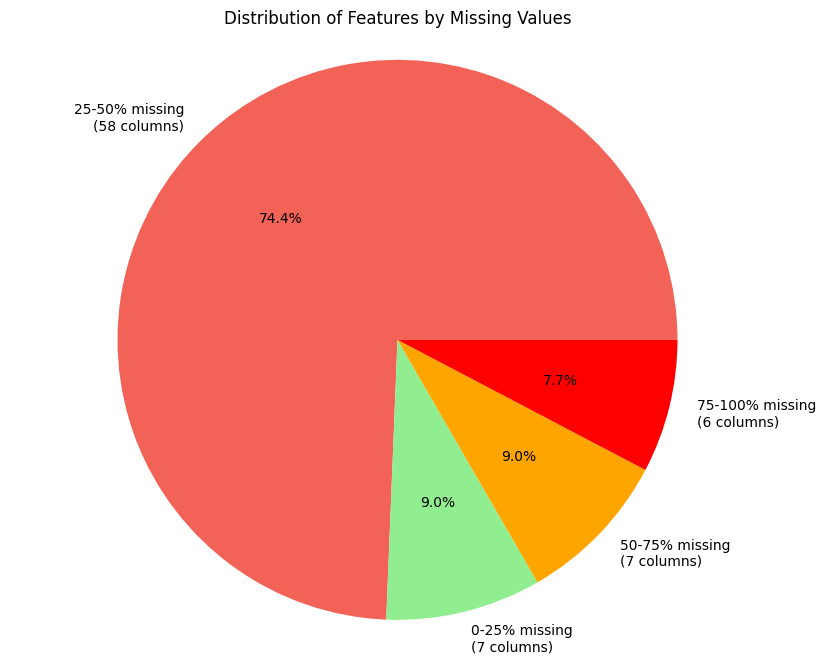

In [36]:
def plot_column_missing_distribution(df):
    # Calculate missing percentage for each column
    df = df.to_pandas()
    missing_percentages = (df.isnull().sum() / len(df)) * 100
    
    # Create categories
    bins = [0, 25, 50, 75, 100]
    labels = ['0-25% missing', '25-50% missing', '50-75% missing', '75-100% missing']
    
    # Count columns in each category
    categories = pd.cut(missing_percentages, bins=bins, labels=labels)
    distribution = categories.value_counts()
    
    # Create pie chart
    plt.figure(figsize=(10, 8))
    colors = ['#F26257','lightgreen', 'orange', 'red']
    
    plt.pie(distribution, 
            labels=[f'{label}\n({count} columns)' for label, count in zip(distribution.index, distribution)],
            colors=colors,
            autopct='%1.1f%%')
    
    plt.title('Distribution of Features by Missing Values')
    plt.axis('equal')
    
    # Print detailed information
    print("\nDetailed column information:")
    for bin_start, bin_end, label in zip(bins[:-1], bins[1:], labels):
        cols = missing_percentages[(missing_percentages > bin_start) & 
                                 (missing_percentages <= bin_end)].index.tolist()
        print(f"\n{label}:")
        for col in cols:
            print(f"- {col}: {missing_percentages[col]:.2f}%")
    
    return plt
fig = plot_column_missing_distribution(train)


Detailed column information:

0-25% missing:
- Physical-Season: 16.41%
- Physical-BMI: 23.69%
- Physical-Height: 23.56%
- Physical-Weight: 22.32%
- FGC-Season: 15.51%
- PreInt_EduHx-Season: 10.61%
- PreInt_EduHx-computerinternet_hoursday: 16.64%

25-50% missing:
- CGAS-Season: 35.48%
- CGAS-CGAS_Score: 38.86%
- Physical-Diastolic_BP: 25.40%
- Physical-HeartRate: 25.08%
- Physical-Systolic_BP: 25.40%
- FGC-FGC_CU: 41.36%
- FGC-FGC_CU_Zone: 42.37%
- FGC-FGC_PU: 41.67%
- FGC-FGC_PU_Zone: 42.65%
- FGC-FGC_SRL: 41.79%
- FGC-FGC_SRL_Zone: 42.75%
- FGC-FGC_SRR: 41.74%
- FGC-FGC_SRR_Zone: 42.70%
- FGC-FGC_TL: 41.31%
- FGC-FGC_TL_Zone: 42.30%
- BIA-Season: 45.83%
- BIA-BIA_Activity_Level_num: 49.72%
- BIA-BIA_BMC: 49.72%
- BIA-BIA_BMI: 49.72%
- BIA-BIA_BMR: 49.72%
- BIA-BIA_DEE: 49.72%
- BIA-BIA_ECW: 49.72%
- BIA-BIA_FFM: 49.72%
- BIA-BIA_FFMI: 49.72%
- BIA-BIA_FMI: 49.72%
- BIA-BIA_Fat: 49.72%
- BIA-BIA_Frame_num: 49.72%
- BIA-BIA_ICW: 49.72%
- BIA-BIA_LDM: 49.72%
- BIA-BIA_LST: 49.72%
- BIA-

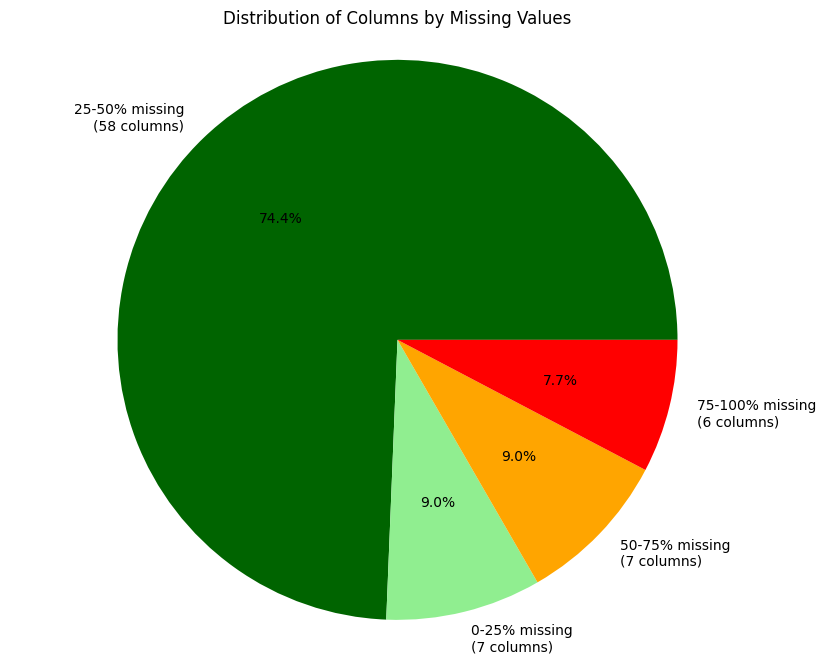